<a href="https://colab.research.google.com/github/hemantkashniyal/EVA4/blob/master/notebooks/EVA4_Session_5_File3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
Add Image Augmentation by adding random rotation to improve accuracy

Add BatchNormalization to each layer to Improve model accuracy

# Result
Parameters: 9.8k

Best Train Accuracy: 98.38 (13th Epoch)

Best Test Accuracy: 99.19 (13th Epoch)

# Analysis

*   Added Image Augmentation by adding Image rotation
*   Added Batch Normalization on each layer
*   Network accuracy reached past 99%


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


import random 
import numpy as np


def reset_seed(seed_value=1):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)

  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)
  if cuda:
      torch.cuda.manual_seed(seed_value)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Normalize Experiment

In [2]:
def get_mean_std(data_type, exp):
  exp_data = exp.data.numpy()
  exp_data = exp.transform(exp_data)

  print('[{}]'.format(data_type))
  print(' - Numpy Shape:', exp.data.cpu().numpy().shape)
  print(' - Tensor Shape:', exp.data.size())
  print(' - min:', torch.min(exp_data))
  print(' - max:', torch.max(exp_data))
  print(' - mean:', torch.mean(exp_data))
  print(' - std:', torch.std(exp_data))
  print(' - var:', torch.var(exp_data))

  data_mean = torch.mean(exp_data).item()
  print("{} data_mean: {}".format(data_type, data_mean))

  data_std = torch.std(exp_data).item()
  print("{} data_std: {}".format(data_type, data_std))

  return data_mean, data_std


!pip install ImageAug
from imageaug.transforms import Colorspace, RandomAdjustment, RandomRotatedCrop
crop_size = (28, 28)
angle_std = 7 # in degrees

# simple transform
simple_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize((28, 28)),
                                      RandomRotatedCrop(crop_size, 0.0, angle_std, downscale=0.5),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      ])
reset_seed()
train = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=simple_transforms)

train_data_mean, train_data_std = get_mean_std("Train", train)
test_data_mean, test_data_std = get_mean_std("Test", test)

CUDA Available? True



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.3882)
 - mean: tensor(0.1296)
 - std: tensor(0.1232)
 - var: tensor(0.0152)
Train data_mean: 0.1296318918466568
Train data_std: 0.12316563725471497
[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.2902)
 - mean: tensor(0.1033)
 - std: tensor(0.0984)
 - var: tensor(0.0097)
Test data_mean: 0.10331299901008606
Test data_std: 0.09836722165346146


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose(
                                      simple_transforms.transforms + [
                                      transforms.Normalize((train_data_mean,), (train_data_std,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize((28, 28)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((train_data_mean,), (train_data_std,))
                                      ])


# Dataset and Creating Train/Test Split

In [4]:
reset_seed()
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
reset_seed()

cuda = torch.cuda.is_available()

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## Training Data

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-1.0525)
 - max: tensor(2.0996)
 - mean: tensor(-2.8951e-07)
 - std: tensor(1.)
 - var: tensor(1.)
torch.Size([512, 1, 28, 28])
torch.Size([512])


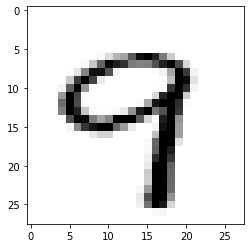

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


### MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

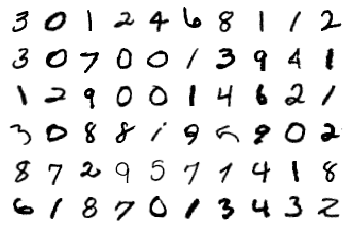

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Test Data

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(-1.0207)
 - max: tensor(1.8768)
 - mean: tensor(-0.0605)
 - std: tensor(0.9373)
 - var: tensor(0.8785)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([512, 1, 28, 28])
torch.Size([512])


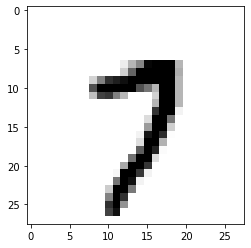

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
test_data = test.test_data
test_data = test.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.test_data.cpu().numpy().shape)
print(' - Tensor Shape:', test.test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

dataiter = iter(test_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


### MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

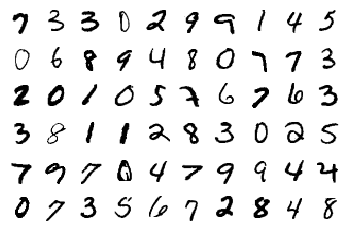

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
bias_bool = True
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        out_channels = 8
        self.convblock0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ) # output_size = 28 RF = 3

        # CONVOLUTION BLOCK 1
        in_channel = out_channels
        out_channels = 8
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ) # output_size = 28 RF = 5

        # TRANSITION BLOCK 1
        in_channel = out_channels
        out_channels = 16
        self.transition1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(1, 1), padding=1, bias=bias_bool),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ) # output_size = 28 RF = 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14 RF = 10

        # CONVOLUTION BLOCK 2
        in_channel = out_channels
        out_channels = 16
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ) # output_size = 14 RF = 12

        # CONVOLUTION BLOCK 3
        in_channel = out_channels
        out_channels = 16
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ) # output_size = 14 RF = 14

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7 RF = 28

        # CONVOLUTION BLOCK 4
        in_channel = out_channels
        out_channels = 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=0, bias=bias_bool),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ) # output_size = 5 RF = 30

        # CONVOLUTION BLOCK 5
        in_channel = out_channels
        out_channels = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=0, bias=bias_bool),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ) # output_size = 3 RF = 32

        # CONVOLUTION BLOCK 6
        in_channel = out_channels
        out_channels = 10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=0, bias=bias_bool),
        ) # output_size = 1 RF = 34

        self.gap = nn.AvgPool2d(1)

    def forward(self, x):
        x = self.convblock0(x)
        x = self.convblock1(x)
        x = self.transition1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool2(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4            [-1, 8, 28, 28]             584
              ReLU-5            [-1, 8, 28, 28]               0
       BatchNorm2d-6            [-1, 8, 28, 28]              16
            Conv2d-7           [-1, 16, 30, 30]             144
              ReLU-8           [-1, 16, 30, 30]               0
       BatchNorm2d-9           [-1, 16, 30, 30]              32
        MaxPool2d-10           [-1, 16, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           2,320
             ReLU-12           [-1, 16, 15, 15]               0
      BatchNorm2d-13           [-1, 16, 15, 15]              32
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [13]:
reset_seed()

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/118 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 0


Loss=0.04855141043663025 Batch_id=117 Accuracy=93.69: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.04492536187171936 Batch_id=117 Accuracy=98.20: 100%|██████████| 118/118 [00:31<00:00,  3.73it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.06267417222261429 Batch_id=117 Accuracy=98.59: 100%|██████████| 118/118 [00:31<00:00,  3.76it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.007092093583196402 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:31<00:00,  3.77it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.05937967076897621 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:31<00:00,  3.77it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.03219833970069885 Batch_id=117 Accuracy=99.01: 100%|██████████| 118/118 [00:31<00:00,  5.37it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.013274803757667542 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:31<00:00,  3.76it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.02807196043431759 Batch_id=117 Accuracy=99.23: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.004889036063104868 Batch_id=117 Accuracy=99.23: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.022436505183577538 Batch_id=117 Accuracy=99.27: 100%|██████████| 118/118 [00:31<00:00,  5.27it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.0014468332519754767 Batch_id=117 Accuracy=99.33: 100%|██████████| 118/118 [00:31<00:00,  6.08it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.005938887596130371 Batch_id=117 Accuracy=99.33: 100%|██████████| 118/118 [00:31<00:00,  3.74it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.0170162171125412 Batch_id=117 Accuracy=99.38: 100%|██████████| 118/118 [00:31<00:00,  5.85it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.010751147754490376 Batch_id=117 Accuracy=99.38: 100%|██████████| 118/118 [00:31<00:00,  3.79it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.018635177984833717 Batch_id=117 Accuracy=99.45: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]



Test set: Average loss: 0.0260, Accuracy: 9906/10000 (99.06%)



Text(0.5, 1.0, 'Test Accuracy')

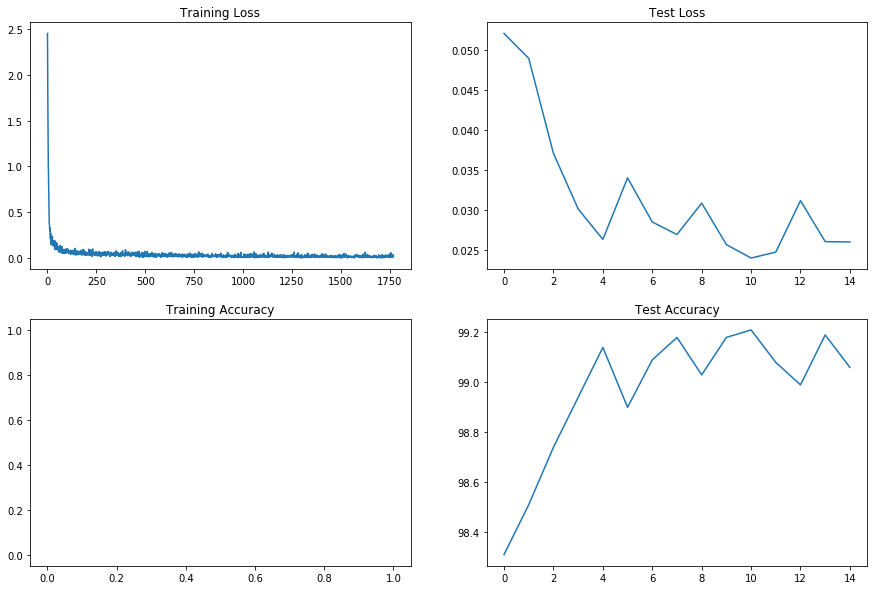

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")